# 1. Setup

## 1.1 Install Dependencies

In [ ]:
!pip install tensorflow  opencv-python matplotlib

## 1.2 Import Dependencies

In [1]:
# Import standard dependencies
import cv2
import os
import random
import numpy as np
from matplotlib import pyplot as plt

In [2]:
# Import tensorflow dependencies - Functional API
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
import tensorflow as tf

## 1.3 Set GPU Growth

In [3]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

## 1.4 Create Folder Structures

In [3]:
# Setup paths
POS_PATH = os.path.join('data', 'positive')
NEG_PATH = os.path.join('data', 'negative')
ANC_PATH = os.path.join('data', 'anchor')

In [ ]:
# Make the directories
os.makedirs(POS_PATH)
os.makedirs(NEG_PATH)
os.makedirs(ANC_PATH)

# 2. Collect Positives and Anchors

## 2.1 Untar Labelled Faces in the Wild Dataset

In [7]:
# http://vis-www.cs.umass.edu/lfw/

In [8]:
# Uncompress Tar GZ Labelled Faces in the Wild Dataset
!tar -xf lfw.tgz

In [9]:
# Move LFW Images to the following repository data/negative
for directory in os.listdir('lfw'):
    for file in os.listdir(os.path.join('lfw', directory)):
        EX_PATH = os.path.join('lfw', directory, file)
        NEW_PATH = os.path.join(NEG_PATH, file)
        os.replace(EX_PATH, NEW_PATH)

## 2.2 Collect Positive and Anchor Classes

In [5]:
# Import uuid library to generate unique image names
import uuid

In [6]:
os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))

'data\\anchor\\80340051-fc45-11ed-9e1d-a4c494bcc347.jpg'

In [6]:
# Establish a connection to the webcam
cap = cv2.VideoCapture(0)
while cap.isOpened(): 
    ret, frame = cap.read()
   
    # Cut down frame to 250x250px
    frame = frame[120:120+250,200:200+250, :]
    
    # Collect anchors 
    if cv2.waitKey(1) & 0XFF == ord('a'):
        # Create the unique file path 
        imgname = os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))
        # Write out anchor image
        cv2.imwrite(imgname, frame)
    
    # Collect positives
    if cv2.waitKey(1) & 0XFF == ord('p'):
        # Create the unique file path 
        imgname = os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1()))
        # Write out positive image
        cv2.imwrite(imgname, frame)
    
    # Show image back to screen
    cv2.imshow('Image Collection', frame)
    
    # Breaking gracefully
    if cv2.waitKey(1) & 0XFF == ord('q'):
        break
        
# Release the webcam
cap.release()
# Close the image show frame
cv2.destroyAllWindows()

In [ ]:
plt.imshow(frame[:250,:250, :])

In [8]:
import os
import uuid

In [ ]:
img_path = os.path.join(ANC_PATH, '924e839c-135f-11ec-b54e-a0cec8d2d278.jpg')
img = cv2.imread(img_path)
augmented_images = data_aug(img)

for image in augmented_images:
    cv2.imwrite(os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1())), image.numpy())

In [ ]:
for file_name in os.listdir(os.path.join(POS_PATH)):
    img_path = os.path.join(POS_PATH, file_name)
    img = cv2.imread(img_path)
    augmented_images = data_aug(img) 
    
    for image in augmented_images:
        cv2.imwrite(os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1())), image.numpy())

# 3. Load and Preprocess Images

## 3.1 Get Image Directories

In [4]:
anchor = tf.data.Dataset.list_files(ANC_PATH+'\*.jpg').take(300)
positive = tf.data.Dataset.list_files(POS_PATH+'\*.jpg').take(300)
negative = tf.data.Dataset.list_files(NEG_PATH+'\*.jpg').take(300)

In [5]:
dir_test = anchor.as_numpy_iterator()

In [6]:
print(dir_test.next())

b'data\\anchor\\80583e6e-ef2a-11ed-bf44-a4c494bcc347.jpg'


## 3.2 Preprocessing - Scale and Resize

In [7]:
def preprocess(file_path):
    
    # Read in image from file path
    byte_img = tf.io.read_file(file_path)
    # Load in the image 
    img = tf.io.decode_jpeg(byte_img)
    
    # Preprocessing steps - resizing the image to be 100x100x3
    img = tf.image.resize(img, (100,100))
    # Scale image to be between 0 and 1 
    img = img / 255.0

    # Return image
    return img

In [8]:
img = preprocess('data\\anchor\\7d46744d-ef2a-11ed-8f0f-a4c494bcc347.jpg')

In [9]:
img.numpy().max() 

1.0

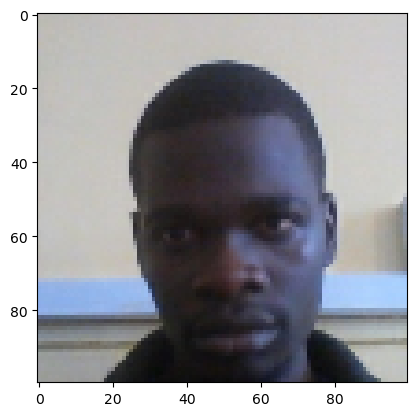

In [10]:
plt.imshow(img)

## 3.3 Create Labelled Dataset

In [12]:
# (anchor, positive) => 1,1,1,1,1
# (anchor, negative) => 0,0,0,0,0

In [13]:
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

In [14]:
samples = data.as_numpy_iterator()

In [15]:
exampple = samples.next()

In [16]:
exampple

(b'data\\anchor\\771ae641-ef2a-11ed-8381-a4c494bcc347.jpg',
 b'data\\positive\\c26a0cd7-ef2a-11ed-9ee5-a4c494bcc347.jpg',
 1.0)

## 3.4 Build Train and Test Partition

In [17]:
def preprocess_twin(input_img, validation_img, label):
    return(preprocess(input_img), preprocess(validation_img), label)

In [18]:
res = preprocess_twin(*exampple)

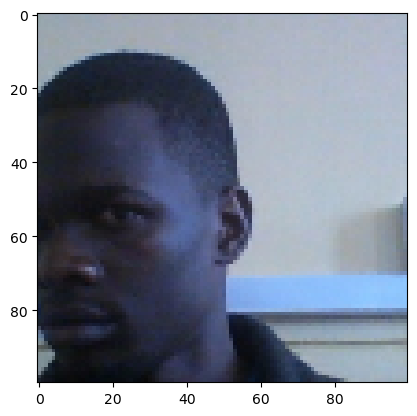

In [19]:
plt.imshow(res[1])

In [20]:
res[2]

1.0

In [21]:
# Build dataloader pipeline
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=10000)

In [22]:
# Training partition
train_data = data.take(round(len(data)*.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

In [23]:
# Testing partition
test_data = data.skip(round(len(data)*.7))
test_data = test_data.take(round(len(data)*.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

# 4. Model Engineering

## 4.1 Build Embedding Layer

In [24]:
inp = Input(shape=(100,100,3), name='input_image')

In [25]:
c1 = Conv2D(64, (10,10), activation='relu')(inp)

In [26]:
m1 = MaxPooling2D(64, (2,2), padding='same')(c1)

In [27]:
c2 = Conv2D(128, (7,7), activation='relu')(m1)
m2 = MaxPooling2D(64, (2,2), padding='same')(c2)

In [28]:
c3 = Conv2D(128, (4,4), activation='relu')(m2)
m3 = MaxPooling2D(64, (2,2), padding='same')(c3)

In [29]:
c4 = Conv2D(256, (4,4), activation='relu')(m3)
f1 = Flatten()(c4)
d1 = Dense(4096, activation='sigmoid')(f1)

In [30]:
mod = Model(inputs=[inp], outputs=[d1], name='embedding')

In [31]:
mod.summary()

Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 100, 100, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 91, 91, 64)        19264     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 46, 46, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 40, 40, 128)       401536    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 20, 20, 128)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 17, 17, 128)       26

In [32]:
def make_embedding(): 
    inp = Input(shape=(100,100,3), name='input_image')
    
    # First block
    c1 = Conv2D(64, (10,10), activation='relu')(inp)
    m1 = MaxPooling2D(64, (2,2), padding='same')(c1)
    
    # Second block
    c2 = Conv2D(128, (7,7), activation='relu')(m1)
    m2 = MaxPooling2D(64, (2,2), padding='same')(c2)
    
    # Third block 
    c3 = Conv2D(128, (4,4), activation='relu')(m2)
    m3 = MaxPooling2D(64, (2,2), padding='same')(c3)
    
    # Final embedding block
    c4 = Conv2D(256, (4,4), activation='relu')(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation='sigmoid')(f1)
    
    
    return Model(inputs=[inp], outputs=[d1], name='embedding')

In [33]:
embedding = make_embedding()

In [34]:
embedding.summary()

Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 100, 100, 3)]     0         
                                                                 
 conv2d_4 (Conv2D)           (None, 91, 91, 64)        19264     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 46, 46, 64)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 40, 40, 128)       401536    
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 20, 20, 128)      0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 17, 17, 128)       26

## 4.2 Build Distance Layer

In [35]:
# Siamese L1 Distance class
class L1Dist(Layer):
    
    # Init method - inheritance
    def __init__(self, **kwargs):
        super().__init__()
       
    # Magic happens here - similarity calculation
    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)

In [36]:
l1 = L1Dist()

In [37]:
#l1(anchor_embedding, validation_embedding)

## 4.3 Make Siamese Model

In [38]:
input_image = Input(name='input_img', shape=(100,100,3))
validation_image = Input(name='validation_img', shape=(100,100,3))

In [39]:
inp_embedding = embedding(input_image)
val_embedding = embedding(validation_image)

In [40]:
siamese_layer = L1Dist()

In [41]:
distances = siamese_layer(inp_embedding, val_embedding)

In [42]:
classifier = Dense(1, activation='sigmoid')(distances)

In [43]:
classifier

<KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'dense_2')>

In [44]:
siamese_network = Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

In [45]:
siamese_network.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img (InputLayer)         [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 validation_img (InputLayer)    [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 embedding (Functional)         (None, 4096)         38960448    ['input_img[0][0]',              
                                                                  'validation_img[0][

In [46]:
def make_siamese_model(): 
    
    # Anchor image input in the network
    input_image = Input(name='input_img', shape=(100,100,3))
    
    # Validation image in the network 
    validation_image = Input(name='validation_img', shape=(100,100,3))
    
    # Combine siamese distance components
    siamese_layer = L1Dist()
    siamese_layer._name = 'distance'
    distances = siamese_layer(embedding(input_image), embedding(validation_image))
    
    # Classification layer 
    classifier = Dense(1, activation='sigmoid')(distances)
    
    return Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

In [47]:
siamese_model = make_siamese_model()

In [48]:
siamese_model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img (InputLayer)         [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 validation_img (InputLayer)    [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 embedding (Functional)         (None, 4096)         38960448    ['input_img[0][0]',              
                                                                  'validation_img[0][

# 5. Training

## 5.1 Setup Loss and Optimizer

In [49]:
binary_cross_loss = tf.losses.BinaryCrossentropy()

In [50]:
opt = tf.keras.optimizers.Adam(1e-4) # 0.0001

## 5.2 Establish Checkpoints

In [51]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(opt=opt, siamese_model=siamese_model)

## 5.3 Build Train Step Function

In [52]:
test_batch = train_data.as_numpy_iterator()

In [53]:
batch_1 = test_batch.next()

In [54]:
X = batch_1[:2]

In [55]:
y = batch_1[2]

In [56]:
y

array([1., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 0.],
      dtype=float32)

In [57]:
@tf.function
def train_step(batch):
    
    # Record all of our operations 
    with tf.GradientTape() as tape:     
        # Get anchor and positive/negative image
        X = batch[:2]
        # Get label
        y = batch[2]
        
        # Forward pass
        yhat = siamese_model(X, training=True)
        # Calculate loss
        loss = binary_cross_loss(y, yhat)
    print(loss)
        
    # Calculate gradients
    grad = tape.gradient(loss, siamese_model.trainable_variables)
    
    # Calculate updated weights and apply to siamese model
    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))
        
    # Return loss
    return loss


## 5.4 Build Training Loop

In [58]:
# Import metric calculations
from tensorflow.keras.metrics import Precision, Recall

In [59]:
def train(data, EPOCHS):
    # Loop through epochs
    for epoch in range(1, EPOCHS+1):
        print('\n Epoch {}/{}'.format(epoch, EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data))
        
        # Creating a metric object 
        r = Recall()
        p = Precision()
        
        # Loop through each batch
        for idx, batch in enumerate(data):
            # Run train step here
            loss = train_step(batch)
            yhat = siamese_model.predict(batch[:2])
            r.update_state(batch[2], yhat)
            p.update_state(batch[2], yhat) 
            progbar.update(idx+1)
        print(loss.numpy(), r.result().numpy(), p.result().numpy())
        
        # Save checkpoints
        if epoch % 10 == 0: 
            checkpoint.save(file_prefix=checkpoint_prefix)

## 5.5 Train the model

In [60]:
EPOCHS = 10

In [ ]:
train(train_data, EPOCHS)


 Epoch 1/10
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
27/27 [==============================] - 1211s 44s/step
0.3387894 0.36231884 1.0

 Epoch 2/10
27/27 [==============================] - 1171s 43s/step
0.0009641032 1.0 1.0

 Epoch 3/10
27/27 [==============================] - 1185s 44s/step
0.0009651901 0.9951923 1.0

 Epoch 4/10
19/27 [====================>.........] - ETA: 5:57

# 6. Evaluate Model

## 6.1 Import Metrics

In [57]:
# Import metric calculations
from tensorflow.keras.metrics import Precision, Recall

## 6.2 Make Predictions

In [58]:
# Get a batch of test data
test_input, test_val, y_true = test_data.as_numpy_iterator().next()

In [59]:
y_hat = siamese_model.predict([test_input, test_val])

1/1 [==============================] - 5s 5s/step


In [60]:
# Post processing the results 
[1 if prediction > 0.5 else 0 for prediction in y_hat ]

[0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1]

In [61]:
y_true

array([1., 0., 1., 1., 1., 1., 0., 0., 0., 1., 1., 0., 1., 0., 0., 1.],
      dtype=float32)

## 6.3 Calculate Metrics

In [62]:
# Creating a metric object 
m = Recall()

# Calculating the recall value 
m.update_state(y_true, y_hat)

# Return Recall Result
m.result().numpy()

0.33333334

In [63]:
# Creating a metric object 
m = Precision()

# Calculating the recall value 
m.update_state(y_true, y_hat)

# Return Recall Result
m.result().numpy()

0.75

In [64]:
r = Recall()
p = Precision()

for test_input, test_val, y_true in test_data.as_numpy_iterator():
    yhat = siamese_model.predict([test_input, test_val])
    r.update_state(y_true, yhat)
    p.update_state(y_true,yhat) 

print(r.result().numpy(), p.result().numpy())

1/1 [==============================] - 2s 2s/step
0.45454547 0.7017544


## 6.4 Viz Results

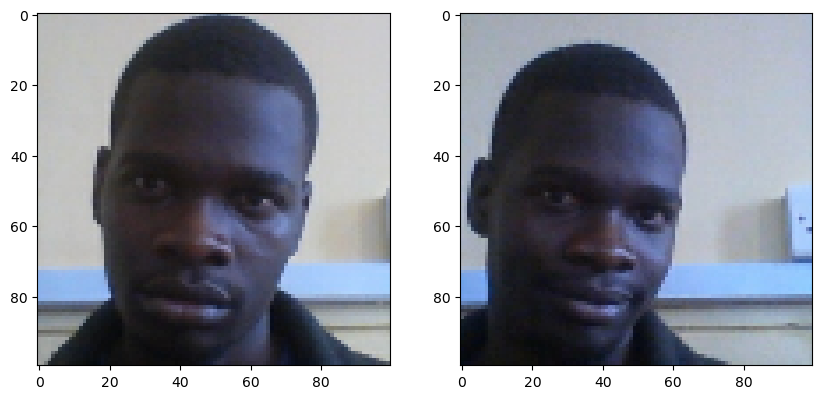

In [66]:
# Set plot size 
plt.figure(figsize=(10,8))

# Set first subplot
plt.subplot(1,2,1)
plt.imshow(test_input[1])

# Set second subplot
plt.subplot(1,2,2)
plt.imshow(test_val[1])

# Renders cleanly
plt.show()

# 7. Save Model

In [88]:
# Save weights
siamese_model.save('siamesemodelv2.h5')

In [76]:
L1Dist

__main__.L1Dist

In [67]:
# Reload model 
siamese_model = tf.keras.models.load_model('siamesemodelv2.h5', 
                                   custom_objects={'L1Dist':L1Dist, 'BinaryCrossentropy':tf.losses.BinaryCrossentropy})

In [68]:
# Make predictions with reloaded model
siamese_model.predict([test_input, test_val])

1/1 [==============================] - 2s 2s/step


array([[9.9996239e-01],
       [9.9999231e-01],
       [9.9999815e-01],
       [9.1709050e-11]], dtype=float32)

In [69]:
# View model summary
siamese_model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img (InputLayer)         [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 validation_img (InputLayer)    [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 embedding (Functional)         (None, 4096)         38960448    ['input_img[0][0]',              
                                                                  'validation_img[0][

# 8. Real Time Test

## 8.1 Verification Function

In [71]:
os.listdir(os.path.join('application_data', 'verification_images'))

['bdfd9f32-ef2a-11ed-b0cf-a4c494bcc347.jpg',
 'be222b3d-ef2a-11ed-ae2c-a4c494bcc347.jpg',
 'be493aee-ef2a-11ed-aaac-a4c494bcc347.jpg',
 'be7869e7-ef2a-11ed-bbee-a4c494bcc347.jpg',
 'be7f7cb2-ef2a-11ed-98ef-a4c494bcc347.jpg',
 'c2384d15-ef2a-11ed-8a17-a4c494bcc347 - Copy.jpg',
 'c25721e8-ef2a-11ed-b57f-a4c494bcc347 - Copy.jpg',
 'c49511d8-ef2a-11ed-8ef9-a4c494bcc347 - Copy.jpg',
 'c51195d9-ef2a-11ed-8715-a4c494bcc347 - Copy.jpg',
 'c58750e2-ef2a-11ed-aaac-a4c494bcc347 - Copy.jpg',
 'c6739b69-ef2a-11ed-824b-a4c494bcc347 - Copy.jpg',
 'c7093b3c-ef2a-11ed-80ef-a4c494bcc347 - Copy.jpg',
 'c897edf9-ef2a-11ed-880b-a4c494bcc347 - Copy.jpg',
 'c8bbf7cb-ef2a-11ed-9fb7-a4c494bcc347 - Copy.jpg',
 'c8ca6bcb-ef2a-11ed-84dc-a4c494bcc347 - Copy.jpg',
 'c900e09e-ef2a-11ed-abed-a4c494bcc347 - Copy.jpg',
 'cb30b97d-ef2a-11ed-8dbf-a4c494bcc347.jpg',
 'cdf8407d-ef2a-11ed-8507-a4c494bcc347 - Copy.jpg',
 'ce1bf415-ef2a-11ed-abed-a4c494bcc347 - Copy.jpg',
 'ce3c96b2-ef2a-11ed-b7ec-a4c494bcc347 - Copy.jpg',
 '

In [72]:
os.path.join('application_data', 'input_image', 'input_image.jpg')

'application_data\\input_image\\input_image.jpg'

In [73]:
for image in os.listdir(os.path.join('application_data', 'verification_images')):
    validation_img = os.path.join('application_data', 'verification_images', image)
    print(validation_img)

application_data\verification_images\bdfd9f32-ef2a-11ed-b0cf-a4c494bcc347.jpg
application_data\verification_images\be222b3d-ef2a-11ed-ae2c-a4c494bcc347.jpg
application_data\verification_images\be493aee-ef2a-11ed-aaac-a4c494bcc347.jpg
application_data\verification_images\be7869e7-ef2a-11ed-bbee-a4c494bcc347.jpg
application_data\verification_images\be7f7cb2-ef2a-11ed-98ef-a4c494bcc347.jpg
application_data\verification_images\c2384d15-ef2a-11ed-8a17-a4c494bcc347 - Copy.jpg
application_data\verification_images\c25721e8-ef2a-11ed-b57f-a4c494bcc347 - Copy.jpg
application_data\verification_images\c49511d8-ef2a-11ed-8ef9-a4c494bcc347 - Copy.jpg
application_data\verification_images\c51195d9-ef2a-11ed-8715-a4c494bcc347 - Copy.jpg
application_data\verification_images\c58750e2-ef2a-11ed-aaac-a4c494bcc347 - Copy.jpg
application_data\verification_images\c6739b69-ef2a-11ed-824b-a4c494bcc347 - Copy.jpg
application_data\verification_images\c7093b3c-ef2a-11ed-80ef-a4c494bcc347 - Copy.jpg
application_dat

In [74]:
def verify(model, detection_threshold, verification_threshold):
    # Build results array
    results = []
    for image in os.listdir(os.path.join('application_data', 'verification_images')):
        input_img = preprocess(os.path.join('application_data', 'input_image', 'input_image.jpg'))
        validation_img = preprocess(os.path.join('application_data', 'verification_images', image))
        
        # Make Predictions 
        result = model.predict(list(np.expand_dims([input_img, validation_img], axis=1)))
        results.append(result)
    
    # Detection Threshold: Metric above which a prediciton is considered positive 
    detection = np.sum(np.array(results) > detection_threshold)
    
    # Verification Threshold: Proportion of positive predictions / total positive samples 
    verification = detection / len(os.listdir(os.path.join('application_data', 'verification_images'))) 
    verified = verification > verification_threshold
    
    return results, verified

## 8.2 OpenCV Real Time Verification

In [76]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()
    frame = frame[120:120+250,200:200+250, :]
    
    cv2.imshow('Verification', frame)
    
    # Verification trigger
    if cv2.waitKey(10) & 0xFF == ord('v'):
        # Save input image to application_data/input_image folder 
#         hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
#         h, s, v = cv2.split(hsv)

#         lim = 255 - 10
#         v[v > lim] = 255
#         v[v <= lim] -= 10
        
#         final_hsv = cv2.merge((h, s, v))
#         img = cv2.cvtColor(final_hsv, cv2.COLOR_HSV2BGR)

        cv2.imwrite(os.path.join('application_data', 'input_image', 'input_image.jpg'), frame)
        # Run verification
        results, verified = verify(siamese_model, 0.5, 0.5)
        print(verified)
    
    if cv2.waitKey(10) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

1/1 [==============================] - 0s 452ms/step
True


In [77]:
np.sum(np.squeeze(results) > 0.9)

48

In [78]:
results

[array([[0.9531548]], dtype=float32),
 array([[0.9573481]], dtype=float32),
 array([[0.9750004]], dtype=float32),
 array([[0.987845]], dtype=float32),
 array([[0.9926905]], dtype=float32),
 array([[0.99306935]], dtype=float32),
 array([[0.9936504]], dtype=float32),
 array([[0.99700594]], dtype=float32),
 array([[0.9967519]], dtype=float32),
 array([[0.99556524]], dtype=float32),
 array([[0.9962137]], dtype=float32),
 array([[0.99882126]], dtype=float32),
 array([[0.9791914]], dtype=float32),
 array([[0.99824]], dtype=float32),
 array([[0.99088675]], dtype=float32),
 array([[0.998119]], dtype=float32),
 array([[0.9969127]], dtype=float32),
 array([[0.8570383]], dtype=float32),
 array([[0.7051293]], dtype=float32),
 array([[0.9941793]], dtype=float32),
 array([[0.9750568]], dtype=float32),
 array([[0.9854578]], dtype=float32),
 array([[0.98194474]], dtype=float32),
 array([[0.90549725]], dtype=float32),
 array([[0.96462846]], dtype=float32),
 array([[0.9952391]], dtype=float32),
 array([